In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torchvision, torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np, sklearn
import torch.nn.functional as F
import os
import requests
import zipfile
import io
from shutil import copyfile

from torchvision.transforms.transforms import CenterCrop, Resize


gds = lambda dataset, cfg: torch.utils.data.DataLoader(
    TensorDataset(*[torch.from_numpy(x) for x in dataset]), batch_size=cfg["batchSize"]
)


def getnorm(dname):
    if dname == "Ci10":
        return (
            torch.from_numpy(
                np.array((0.4914, 0.4822, 0.4465), np.float32).reshape(1, 3, 1, 1)
            ).cuda(),
            torch.from_numpy(
                np.array((0.2023, 0.1994, 0.2010), np.float32).reshape(1, 3, 1, 1)
            ).cuda(),
        )
    elif dname == "Ci100":
        return (
            torch.from_numpy(
                np.array((0.5060725, 0.48667726, 0.4421305), np.float32).reshape(
                    1, 3, 1, 1
                )
            ).cuda(),
            torch.from_numpy(
                np.array((0.2675421, 0.25593522, 0.27593908), np.float32).reshape(
                    1, 3, 1, 1
                )
            ).cuda(),
        )
    elif dname == "Fash":
        return (
            torch.from_numpy(np.array((0.281), np.float32).reshape(1, 1, 1, 1)).cuda(),
            torch.from_numpy(np.array((0.352), np.float32).reshape(1, 1, 1, 1)).cuda(),
        )
    elif dname == "MNIST":
        return (
            torch.from_numpy(np.array((0.1307), np.float32).reshape(1, 1, 1, 1)).cuda(),
            torch.from_numpy(np.array((0.3081), np.float32).reshape(1, 1, 1, 1)).cuda(),
        )
    elif dname == "TinyImgNet":
        return (
            torch.from_numpy(
                np.array((0.4802, 0.4481, 0.3975), np.float32).reshape(3, 1, 1)
            ),
            torch.from_numpy(
                np.array((0.2302, 0.2265, 0.2262), np.float32).reshape(3, 1, 1)
            ),
        )


def getFullDS(cfg, reconstr=False):
    dname = cfg["ds"][0]
    trans = transforms.Compose([transforms.ToTensor()])
    refu = lambda x: F.interpolate(x.unsqueeze(0), size=64).squeeze(0)
    if dname == "Ci10":
        cdat = (
            torchvision.datasets.CIFAR10
        )  # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) #transform = transforms.Compose([transforms.ToTensor(), norm])
        cfg["imCh"] = 3
    elif dname == "Ci100":
        cdat = (
            torchvision.datasets.CIFAR100
        )  # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        cfg["imCh"] = 3
    elif dname == "Fash":
        cdat = torchvision.datasets.FashionMNIST
        # img = img - np.array([0.281])            img = img / np.array([0.352])
        trans = transforms.Compose([transforms.ToTensor(), refu])
        cfg["imCh"] = 1
    elif dname == "MNIST":
        cdat = torchvision.datasets.MNIST
        # trans = transforms.Compose([transforms.ToTensor(), refu, transforms.Normalize(0.1307,0.3081)])
        trans = transforms.Compose([transforms.ToTensor(), refu])
        cfg["imCh"] = 1
    elif dname == "TinyImgNet":
        cdat = tinyImgNet
        norm = getnorm(dname)
        # gamma_corr = lambda img : transforms.functional.adjust_gamma(img, gamma=, float=)
        # resize_tr = random.choice([transforms.RandomResizedCrop(56), transforms.CenterCrop(56)])
        # aug_tr = random.choice([transforms.RandomHorizontalFlip(), transforms.RandomAffine(30, translate=10, scale = [0.8])])
        # data_augs = [transforms.RandomResizedCrop(32), transforms.RandomCrop(32), transforms.RandomHorizontalFlip(), transforms.RandomRotation(45)]
        train_trans = transforms.Compose(
            [
                transforms.ToTensor(),
                #transforms.Normalize(mean=norm[0], std=norm[1]),
                transforms.RandomResizedCrop(64),
                # transforms.CenterCrop(56),
                # transforms.Resize(32),
                transforms.RandomHorizontalFlip(),
            ]
        )
        val_trans = transforms.Compose(
            [
                transforms.ToTensor(),
                # transforms.CenterCrop(56),
                #transforms.Normalize(mean=norm[0], std=norm[1]),
                # transforms.Resize(32)
            ]
        )
        cfg["imCh"] = 3

    ntrain, down = cfg["ntrain"], True
    if dname == "TinyImgNet":
        down = True
        if reconstr == True:
            trainset = cdat(
                root="data/",
                train=True,
                download=down,
                transform=transforms.Compose([transforms.ToTensor()]),
            )
            valset = cdat(
                root="data/",
                train=False,
                download=down,
                transform=transforms.Compose([transforms.ToTensor()]),
            )

        else:
            trainset = cdat(
                root="data/", train=True, download=down, transform=train_trans
            )
            valset = cdat(root="data/", train=False, download=down, transform=val_trans)
        train_loader = DataLoader(
            trainset, batch_size=cfg["batchSize"], shuffle=True, num_workers=4
        )
        val_loader = DataLoader(
            valset, batch_size=cfg["batchSize"], shuffle=False, num_workers=4
        )
        return train_loader, val_loader, None, trainset, valset

    def loadStore(isTrain, ndat):
        nonlocal cdat
        trainset = cdat(root="data/", train=isTrain, download=down, transform=trans)
        train_dataset = torch.utils.data.DataLoader(
            trainset, batch_size=ndat, num_workers=4
        )  # cfg["batchSize"]
        ds = next(iter(train_dataset))
        X, Y = ds[0].clone().numpy(), ds[1].clone().numpy()
        # normA = lambda bx: (bx - np.min(bx)) / (np.max(bx) - np.min(bx) + 1e-10)  # "Normalizing - necessary if no BN"
        # X,Y = normA(X), normA(Y)
        ds = [X, Y]
        print(
            "Data stats",
            cdat,
            X.shape,
            np.mean(X, axis=(0, 2, 3)),
            np.std(X, axis=(0, 2, 3)),
            np.max(X),
            np.min(X),
            " Data should be normalized",
        )
        ds = sklearn.utils.shuffle(*ds)
        return ds[0].astype(np.float16), ds[1].astype(np.int16)

    trX, trY = loadStore(True, ntrain)
    teX, teY = loadStore(False, ntrain // 2)

    def cds(trX, trY, shuffle=True):
        ds = TensorDataset(torch.from_numpy(trX), torch.from_numpy(trY))
        return DataLoader(
            ds, batch_size=cfg["batchSize"], shuffle=shuffle, num_workers=4
        )

    return cds(trX, trY), cds(teX, teY, False), None


def tinyImgNet(root: str, train: bool, download: bool, transform) -> Dataset:
    filter_val = train and not download

    if download:
        os.makedirs(root, exist_ok=True)
        r = requests.get(
            "http://cs231n.stanford.edu/tiny-imagenet-200.zip", stream=True
        )
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(root)

    main_dir_path = os.path.join(root, "tiny-imagenet-200")
    train_path = os.path.join(main_dir_path, "train")
    val_path = os.path.join(main_dir_path, "val")
    if not (os.path.exists(train_path) and os.path.exists(val_path)):
        raise ValueError("Train and Val paths don't exist")

    val_formatted = os.path.join(main_dir_path, "val_formatted")
    if not filter_val and not os.path.exists(val_formatted):
        with open(os.path.join(val_path, "val_annotations.txt"), "r") as f:
            img_class_map = f.readlines()
        for img_class in img_class_map:
            img_name, class_name = img_class.split("\t")[0], img_class.split("\t")[1]
            img_path = os.path.join("images", img_name)
            class_dir = os.path.join(val_formatted, class_name)
            os.makedirs(os.path.join(class_dir, "images"), exist_ok=True)
            copyfile(
                os.path.join(val_path, img_path), os.path.join(class_dir, img_path)
            )
    if train:
        return ImageFolder(train_path, transform)
    else:
        return ImageFolder(val_formatted, transform)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as tca
from tqdm import tqdm

from torch import nn

def conv3x3(in_planes, out_planes, stride=1, bias=False):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=1, bias=bias)

def variable_init(m, neg_slope=0.0):
  if isinstance(m, (nn.Linear, nn.Conv2d)):
    nn.init.kaiming_uniform_(m.weight.data, neg_slope)
    if m.bias is not None:
      m.bias.data.zero_()
  elif isinstance(m, nn.BatchNorm2d):
    if m.weight is not None:
      m.weight.data.fill_(1)
    if m.bias is not None:
      m.bias.data.zero_()
    m.running_mean.zero_()
    m.running_var.zero_()

class PlusMinusOne(object):
  """ Scales values that are between [0, 1] into [-1, 1]. """
  
  def __init__(self):
    pass

  def __call__(self, x):
    x = 2.0 * x - 1.0
    return x    

def _down_sample(x):
  return nn.functional.avg_pool2d(x, 2, 2)

def _increase_planes(x, n_out_planes):
  n_samples, n_planes, spatial_size = x.size()[:-1]
  x_zeros = torch.zeros(
    n_samples, n_out_planes - n_planes, spatial_size, spatial_size, 
    dtype=x.dtype, device=x.device)
  return torch.cat([x, x_zeros], 1)

def _downsample_and_increase_planes(x, n_out_planes):
  x = _down_sample(x)
  x = _increase_planes(x, n_out_planes)
  return x

def identity_func(n_in_planes, n_out_planes, stride):
  identity = lambda x: x
  if stride == 2 and n_in_planes != n_out_planes:
    identity = lambda x: _downsample_and_increase_planes(x, n_out_planes)
  elif stride == 2:
    identity = _down_sample
  elif n_in_planes != n_out_planes:
    identity = lambda x: _increase_planes(x, n_out_planes)
  return identity

class BasicBlock(nn.Module):

  expansion = 1

  def __init__(self, n_in_planes, n_out_planes, stride=1):
    super().__init__()
    assert stride == 1 or stride == 2

    self.block = nn.Sequential(
      conv3x3(n_in_planes, n_out_planes, stride),
      nn.BatchNorm2d(n_out_planes),
      nn.ReLU(inplace=True),
      conv3x3(n_out_planes, n_out_planes),
      nn.BatchNorm2d(n_out_planes)
    )

    self.identity = identity_func(n_in_planes, n_out_planes, stride)

  def forward(self, x):
    out = self.block(x)
    identity = self.identity(x)

    out += identity
    out = nn.functional.relu(out)
    return out

class Bottleneck(nn.Module):

  expansion = 4

  def __init__(self, n_in_planes, n_out_planes, stride=1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(n_in_planes, n_out_planes, kernel_size=1)
    self.bn1 = nn.BatchNorm2d(n_out_planes)

    self.conv2 = conv3x3(n_out_planes, n_out_planes, stride)
    self.bn2 = nn.BatchNorm2d(n_out_planes)

    self.conv3 = nn.Conv2d(n_out_planes, n_out_planes * 4, kernel_size=1)
    self.bn3 = nn.BatchNorm2d(n_out_planes * 4)

    self.relu = nn.ReLU(inplace=True)
    self.identity = identity_func(n_in_planes, n_out_planes * 4, stride)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    identity = self.identity(x)
    out += identity
    out = self.relu(out)

    return out

class ResNet(nn.Module):

  def __init__(self, block, 
                     n_blocks, 
                     n_output_planes, 
                     n_classes,
                     inch):
    super(ResNet, self).__init__()
    assert len(n_blocks) == 4
    assert len(n_output_planes) == 4
    
    self.n_in_planes = n_output_planes[0]

    self.layer0 = nn.Sequential(
      conv3x3(inch, self.n_in_planes),
      nn.BatchNorm2d(self.n_in_planes),
      nn.ReLU(inplace=True)
    )
    self.layer1 = self._make_layer(block, n_blocks[0], n_output_planes[0])
    self.layer2 = self._make_layer(block, n_blocks[1], n_output_planes[1], 2)
    self.layer3 = self._make_layer(block, n_blocks[2], n_output_planes[2], 2)
    self.layer4 = self._make_layer(block, n_blocks[3], n_output_planes[3], 2)
    self.fc = nn.Linear(n_output_planes[3] * block.expansion, n_classes, False)

    self.apply(variable_init)

  def _make_layer(self, block, n_blocks, n_out_planes, stride=1):
    layers = []
    layers.append(block(self.n_in_planes, n_out_planes, stride))
    self.n_in_planes = n_out_planes * block.expansion
    for i in range(1, n_blocks):
      layers.append(block(self.n_in_planes, n_out_planes))

    return nn.Sequential(*layers)

  def features(self, x):
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    spatial_size = x.size(2)
    x = nn.functional.avg_pool2d(x, spatial_size, 1)
    x = x.view(x.size(0), -1)
    return x

  def forward(self, x):
    x = self.features(x)
    x = self.fc(x)
    return x

def ResNet10(**kwargs):
  return ResNet(BasicBlock, [1,1,1,1], **kwargs)

def ResNet18(**kwargs):
  return ResNet(BasicBlock, [2,2,2,2], **kwargs)

def ResNet34(**kwargs):
  return ResNet(BasicBlock, [3,4,6,3], **kwargs)

def ResNet50(**kwargs):
  return ResNet(Bottleneck, [3,4,6,3], **kwargs)


def decay(opt,epoch,optimizerCl):
    if opt[0] == "S" and (epoch + 1) % (opt[1] // 3+opt[1]//10+2 ) == 0:
        for p in optimizerCl.param_groups: p['lr'] *= 0.1
        #print("  D", np.round(optimizerCl.param_groups[0]['lr'],5))

def getAcc(net, dataset,  niter=10000,norm=None):
    correct,total = 0,0
    net.eval()
    with torch.no_grad():
        for cit,data in enumerate(dataset):
            with tca.autocast():
                dsx,dsy = data[0].cuda(),data[1].cuda()
                if len(dsx.size()) == 5:
                    dsx = dsx.squeeze(0)
                    dsy = dsy.squeeze(0)
                total += dsy.size(0)
                outputs = net(dsx.float())
                _, predicted = torch.max(outputs.data, 1)
                correct += torch.eq(predicted, dsy).sum().item()
                if cit>=niter: break
    return correct/total


def getclassifier(cfg,train_dataset,val_dataset,norm=None):

    netCl=ResNet10(n_classes = cfg["ds"][1], n_output_planes = [64, 128, 256, 512], inch = cfg["imCh"]).cuda()
    # if cfg["ds"][0] == "TinyImgNet":
    #     optimizerCl = optim.Adam(netCl.parameters(), lr=cfg["opt"][2], weight_decay=cfg["opt"][3])
    # else:
    #     optimizerCl = optim.SGD(netCl.parameters(), lr=cfg["opt"][2], momentum=0.9, weight_decay=cfg["opt"][3])
    optimizerCl = optim.SGD(netCl.parameters(), lr=cfg["opt"][2], momentum=0.9, weight_decay=cfg["opt"][3])
    closs,teaccs,trep,loss,clr = 0,[],cfg["opt"][1],nn.CrossEntropyLoss(), cfg["opt"][2]
    print("Train Classifier to explain")
    scaler = tca.GradScaler()
    teAccs,trAccs=[],[]
    clAcc = lambda dataset: getAcc(netCl, dataset,  niter=1e10,norm=norm)
    for epoch in tqdm(range(trep)):
        netCl.train()
        for i, data in enumerate(tqdm(train_dataset, position=0, leave=True)):
          with tca.autocast():
            optimizerCl.zero_grad()
            dsx = data[0]
            dsx,dsy = dsx.cuda(),data[1].cuda()
            if len(dsx.size()) == 5:
                dsx = dsx.squeeze(0)
                dsy = dsy.squeeze(0)
            output = netCl(dsx.float())
            errD_real = loss(output, dsy.long())
            scaler.scale(errD_real).backward()
            scaler.step(optimizerCl)
            scaler.update()
            closs = 0.97 * closs + 0.03 * errD_real.item() if i > 20 else 0.8 * closs + 0.2 * errD_real.item()
        decay(cfg["opt"],epoch,optimizerCl)
        netCl.eval()
        teAccs.append(clAcc(val_dataset))
        if (epoch % 4 == 0 and epoch<=13) or (epoch % 20==0 and epoch>13):
            print(epoch, np.round(np.array([closs, teAccs[-1], clAcc(train_dataset)]), 5))
    lcfg = {"testAcc": clAcc(val_dataset), "trainAcc": clAcc(train_dataset)}
    netCl.eval()
    return netCl, lcfg

In [4]:
import numpy as np
import torch.cuda.amp as tca
import torch
from torch import nn
import pdb
from tqdm import tqdm
import torchvision.transforms as transforms


class ClaDecNet(nn.Module):
    def __init__(self, cfg, inShape, nFea):
        super(ClaDecNet, self).__init__()
        self.channel_mult = int(64)
        self.expLinLay = len(inShape) == 2  # linear layer...
        dim = 64 if self.expLinLay else 64 // int(inShape[-1])  # dimension of input
        self.input_dim = np.prod(inShape[1:])
        self.inFea = inShape[-2] if not self.expLinLay else 1
        nLay = int(np.round(np.log2(dim) - 2))
        # Use batchnorm or bias? LeakyRelu or Relu   -->  Does not make much of a difference
        # bn,bias = lambda x:  nn.BatchNorm2d(x),False
        # rel =lambda x:  nn.LeakyReLU(0.01)
        bn, bias = lambda x: nn.Identity(), True
        rel = lambda x: nn.ReLU()

        if (
            self.inFea == 1
        ):  # There is no spatial dimension (or it is one) -> use a dense layer as the first layer
            self.useDense = True
            self.fc_output_dim = max(
                self.input_dim, self.channel_mult
            )  # number of input features
            self.fc = nn.Sequential(
                nn.Linear(self.input_dim, self.fc_output_dim), nn.ReLU(True)
            )  # , nn.BatchNorm1d(self.fc_output_dim)
        else:  # The spatial extend is larger one, use a conv layer, otherwise have too many parameters
            self.fc_output_dim = inShape[1]  # number of input features
            self.fc = nn.Sequential(
                nn.Conv2d(inShape[1], inShape[1], 3, stride=1, padding=1, bias=bias),
                nn.ReLU(True),
            )  # , nn.BatchNorm1d(self.fc_output_dim)
            self.useDense = False
        temp_nLay = 0
        if nLay < 0:
            temp_nLay = nLay
            nLay = 0

        self.deconv = [
            nn.ConvTranspose2d(
                self.fc_output_dim,
                int(self.channel_mult * (2 ** nLay)),
                4,
                stride=2,
                padding=1,
                bias=bias,
            ),
            bn(int(self.channel_mult * (2 ** nLay))),
            rel(None),
        ]
        if temp_nLay < 0:
            self.deconv.append(nn.MaxPool2d((2,2), stride=2))
        for j in range(nLay, 0, -1):
            self.deconv += [
                nn.ConvTranspose2d(
                    int(self.channel_mult * (2 ** j)),
                    int(self.channel_mult * (2 ** (j - 1))),
                    4,
                    stride=2,
                    padding=1,
                    bias=bias,
                ),
                bn(self.channel_mult * (2 ** (j - 1))),
                rel(None),
            ]
        self.deconv.append(
            nn.ConvTranspose2d(
                self.channel_mult * 1, nFea, 4, stride=2, padding=1, bias=True
            )
        )
        if temp_nLay < -1:
            self.deconv.append(nn.MaxPool2d((2,2), stride=2))
        self.deconv = nn.Sequential(*self.deconv)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        if self.useDense:
            x = x.view(-1, self.input_dim)
            x = self.fc(x)
            x = x.view(-1, self.fc_output_dim, self.inFea, self.inFea)
        else:
            x = self.fc(x)
        x = self.deconv(x)
        x = self.sig(
            x
        )  # This sometimes gives better visualization, but you need to take care to standardize inputs as well
        return x


def getClaDec(cfg, netCl, norm, train_dataset):
    alpha = cfg["alpha"]
    closs, cclloss, crloss, teaccs, trep, clloss, clr = (
        0,
        0,
        0,
        [],
        cfg["opt"][1],
        nn.CrossEntropyLoss(),
        cfg["opt"][2],
    )
    print("Train CLaDec")
    scaler = tca.GradScaler()
    d = next(iter(train_dataset))
    netDec = ClaDecNet(cfg, d[2].squeeze(0).shape, cfg["imCh"]).cuda()
    netDec.train()
    netCl.train()
    optimizerCl = torch.optim.Adam(netDec.parameters(), lr=0.0003, weight_decay=1e-5)
    aeloss = nn.MSELoss()
    ulo = (
        lambda closs, totloss, i: 0.97 * closs + 0.03 * totloss.item()
        if epoch > 20
        else 0.8 * closs + 0.2 * totloss.item()
    )
    for epoch in tqdm(range(trep)):
        for i, data in enumerate(train_dataset):
            with tca.autocast():
                optimizerCl.zero_grad()
                if cfg["ds"][0] == "TinyImgNet":
                    dsx, dsy, dsact = (
                        data[0].squeeze(0).cuda(),
                        data[1].squeeze(0).cuda(),
                        data[2].squeeze(0).cuda(),
                    )
                else:
                    dsx, dsy, dsact = data[0].cuda(), data[1].cuda(), data[2].cuda()
                output = netDec(dsact.float())
                recloss = aeloss(output, dsx)
                if cfg["ds"][0] == "TinyImgNet":
                    norm = getnorm("TinyImgNet")
                    transform = transforms.Compose(
                        [
                            transforms.Normalize(mean=norm[0], std=norm[1]),
                            transforms.RandomResizedCrop(64),
                            transforms.RandomHorizontalFlip(),
                        ]
                    )
                    claloss = clloss(netCl(transform(output)), dsy.long())
                else:
                    claloss = clloss(netCl(output), dsy.long())
                totloss = (1 - alpha) * recloss + alpha * claloss
                scaler.scale(totloss).backward()
                scaler.step(optimizerCl)
                scaler.update()
                closs, cclloss, crloss = (
                    ulo(closs, totloss, epoch),
                    ulo(cclloss, claloss, epoch),
                    ulo(crloss, recloss, epoch),
                )

        decay(cfg["opt"], epoch, optimizerCl)
        if (epoch % 2 == 0 and epoch <= 10) or (epoch % 10 == 0 and epoch > 10):
            print(epoch, np.round(np.array([closs, crloss, cclloss]), 5))

    lcfg = {"ClaLo": closs}
    netDec.eval()
    return netDec, lcfg


def getActModel(cfg, classifier):
    ind = cfg["layInd"]
    actModel = nn.Sequential(*list(classifier.children())[:ind])
    actModel.eval()
    return actModel


class RefAE(nn.Module):
    def __init__(self, cfg, inShape):
        super(RefAE, self).__init__()
        self.cladec = ClaDecNet(cfg, inShape, cfg["imCh"])
        self.cladec.train()
        cla = ResNet10(n_classes = cfg["ds"][1], n_output_planes = [64, 128, 256, 512], inch = cfg["imCh"]).cuda()
        actModel = getActModel(cfg, cla)
        actModel.train()
        self.seq = nn.Sequential(actModel, self.cladec)

    def forward(self, x):
        return self.seq(x)


def getRefAE(cfg, acts, train_dataset):
    closs, teaccs, trep, clloss, clr = (
        0,
        [],
        cfg["opt"][1],
        nn.CrossEntropyLoss(),
        cfg["opt"][2],
    )
    print("Train RefAE")
    scaler = tca.GradScaler()
    d = next(iter(acts))
    netDec = RefAE(cfg, d[2].squeeze(0).shape).cuda()
    netDec.train()
    optimizerCl = torch.optim.Adam(netDec.parameters(), lr=0.0003, weight_decay=1e-5)
    aeloss = nn.MSELoss()
    ulo = (
        lambda closs, totloss, i: 0.97 * closs + 0.03 * totloss.item()
        if epoch > 20
        else 0.8 * closs + 0.2 * totloss.item()
    )
    for epoch in tqdm(range(trep)):
        for i, data in enumerate(train_dataset):
            with tca.autocast():
                # optimizerCl.zero_grad()
                # if cfg["ds"][0] == "TinyImgNet":
                #     dsx = data[0].squeeze(0).cuda()
                # else:
                #     dsx = data[0].cuda()
                dsx = data[0].cuda()
                output = netDec(dsx.float())
                recloss = aeloss(output, dsx)
                scaler.scale(recloss).backward()
                scaler.step(optimizerCl)
                scaler.update()
                closs = ulo(closs, recloss, epoch)

        decay(cfg["opt"], epoch, optimizerCl)
        if (epoch % 2 == 0 and epoch <= 10) or (epoch % 10 == 0 and epoch > 10):
            print(epoch, np.round(np.array([closs]), 5))

    lcfg = {"RefAELo": closs}
    netDec.eval()
    return netDec, lcfg


In [5]:
import torch
from torch.utils.data import TensorDataset, Dataset, IterableDataset
import numpy as np,os
import torch.cuda.amp as tca
from matplotlib import pyplot as plt
import pdb
from tqdm import tqdm
class LargeActDataset(IterableDataset):
    def __init__(self, orig_loader, act_model, device):
        super(LargeActDataset, self).__init__()
        self.orig_loader = orig_loader
        self.act_model = act_model
        self.device = device


    def __iter__(self) :
        for (img, label) in self.orig_loader:
            with torch.no_grad():
                with tca.autocast():
                    act = self.act_model(img.to(self.device)).detach().cpu()
            yield (img.detach().cpu(), label, act)

def getActs(ds,actModel,cfg):
    dsact = LargeActDataset(ds, actModel, cfg["device"])
    return torch.utils.data.DataLoader(dsact, 
                                       batch_size=1)
import torchvision.transforms as transforms

class LargeReconstrDataset(IterableDataset):
    def __init__(self, orig_loader, model, device, train):
        super(LargeReconstrDataset, self).__init__()
        self.orig_loader = orig_loader
        self.model = model
        self.device = device
        norm = getnorm("TinyImgNet")
        tr_list = [transforms.Normalize(mean = norm[0], std=norm[1])]
        if train:
            tr_list.append(transforms.RandomResizedCrop(64))
            tr_list.append(transforms.RandomHorizontalFlip())
            
        self.transform = transforms.Compose(tr_list)

    def __iter__(self) :
        for (img, label) in self.orig_loader:
            with torch.no_grad():
                with tca.autocast():
                    reconstr = self.model(img.to(self.device)).detach().cpu()
                reconstr = self.transform(reconstr)
            yield (reconstr, label)

def getReconstr(ds,model,cfg, train):
    dsact = LargeReconstrDataset(ds, model, cfg["device"], train)
    return torch.utils.data.DataLoader(dsact, batch_size=1)

def getReconstrDS(acts_ds,refAE,cladecNet):
    cladec_loss, refae_loss = 0, 0
    for i, data in enumerate(tqdm(acts_ds, position=0, leave=True)):
        #if i > 2: break
        with tca.autocast():
            with torch.no_grad():
                dsx, dsact = data[0].cuda(), data[2].cuda()
                if len(dsx.size()) == 5:
                    dsx = dsx.squeeze(0)
                    dsact = dsact.squeeze(0)
                outCla = cladecNet(dsact).detach().cpu().float()
                outAE = refAE(dsx).detach().cpu().float()
                dsx = dsx.detach().squeeze().cpu().float()
                cladec_loss += (outCla - dsx).pow(2).mean()
                refae_loss += (outAE - dsx).pow(2).mean()
    
    
    refae_loss = refae_loss/i
    cladec_loss = cladec_loss/i
    return cladec_loss, refae_loss
        #X=torch.cat(X,dim=0)
        #y=torch.cat(y, dim=0)
        #dsact=TensorDataset(X,y,conacts)
        #return torch.utils.data.DataLoader(dsact, batch_size=cfg["batchSize"], shuffle=True, num_workers=4)



In [6]:
dummy=False
#dummy = True
#cfg={ 'ds': ('Fash', 10),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
#      'batchSize': 128, 'opt': ('S', 1 if dummy else 64, 0.1, 0.0001), #optimizer settings
#      'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
#      'alpha': 0.001, #tradeoff parameter reconstruction vs. classification loss
#      'ntrain': 500 if dummy else 60000}
cfg={ 'ds': ('TinyImgNet', 200),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
    'batchSize': 128, 'opt': ('S', 1 if dummy else 60, 0.1, 0.0001), #optimizer settings
    'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
    'alpha': 1e-6, #tradeoff parameter reconstruction vs. classification loss
    'ntrain': 500 if dummy else 100000}
print("Executing config",cfg)
cfg["num_classes"]=cfg["ds"][1]
cfg["imCh"] = 3

Executing config {'ds': ('TinyImgNet', 200), 'batchSize': 128, 'opt': ('S', 60, 0.1, 0.0001), 'layInd': -1, 'alpha': 1e-06, 'ntrain': 100000}


In [7]:
#Get Data
print("Get dataset")
train_loader, val_loader,_, trainset, valset=getFullDS(cfg)


Get dataset


In [8]:
model_path = "trained_models/resnet/TinyImgNet_final/TinyImgNet_final"
import os
os.makedirs(model_path, exist_ok=True)

In [ ]:
%%time
# Train and save non-reflective Model
cfg["opt"] = ('S', 1 if dummy else 60, 0.1, 0.0001)

classifier, lcfg = getclassifier(cfg,  train_loader, val_loader, norm=None)
print("Classifier Accuracy",lcfg)
torch.save(classifier.state_dict(), os.path.join(model_path, "classifier.pt"))


  0%|          | 0/782 [00:00<?, ?it/s]

Train Classifier to explain


  0%|          | 0/782 [00:00<?, ?it/s]

0 [4.36983 0.0996  0.09154]


  0%|          | 0/782 [00:00<?, ?it/s]

4 [3.2829  0.2594  0.24107]


  0%|          | 0/782 [00:00<?, ?it/s]

8 [2.87909 0.3666  0.32524]


  0%|          | 0/782 [00:00<?, ?it/s]

12 [2.69262 0.3757  0.35682]


  0%|          | 0/782 [00:00<?, ?it/s]

20 [2.44002 0.4234  0.4226 ]


  0%|          | 0/782 [00:00<?, ?it/s]

40 [1.68699 0.5474  0.60789]


100%|██████████| 60/60 [1:51:15<00:00, 111.26s/it]


Classifier Accuracy {'testAcc': 0.5657, 'trainAcc': 0.66517}
CPU times: user 1h 49min 55s, sys: 2min 21s, total: 1h 52min 17s
Wall time: 1h 51min 56s


In [ ]:
children = list(classifier.children())

In [10]:
classifier = ResNet10(n_classes = cfg["ds"][1], n_output_planes = [64, 128, 256, 512], inch = cfg["imCh"]).cuda()
classifier.load_state_dict(torch.load(os.path.join(model_path, "classifier.pt")))
classifier.eval()

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): 

In [11]:
_, val_loader,_, _, _=getFullDS(cfg, reconstr=True)
classifier.eval()


ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): 

In [14]:
import torch
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image


def save_reconstructions(cfg, data_loader, model_path, model, train=True, cladec=True):
    rec_path = os.path.join(model_path, "rec_cladec" if cladec else "rec_refae", "reconstructions_{}".format(str(-1*cfg["layInd"])))
    os.makedirs(rec_path, exist_ok = True)
    dset_path = os.path.join(rec_path, "train" if train else "val")
    os.makedirs(dset_path, exist_ok=True)
    img_tr = transforms.ToPILImage()
    total_classes = set()
    idx = 0
    for (img, label) in tqdm(data_loader, position=0, leave=True):
        label = np.array(label)
        if len(total_classes) < cfg["ds"][1]:
            label_classes = set(label)
            new_classes = label_classes.difference(total_classes)
            total_classes = total_classes.union(label_classes)
            for i in new_classes:
                class_path = os.path.join(dset_path, str(i))
                os.makedirs(class_path, exist_ok=True)
        
        with tca.autocast():
            act = model(img.to(cfg["device"])).detach().cpu()
        for j in range(len(img)):
            idx +=1
            vec = img_tr(act[j])
            vec_label = label[j]
            vec_path = os.path.join(dset_path, str(vec_label),str(idx) + ".jpg")
            vec.save(vec_path)

In [16]:
cfg["device"] = torch.device("cuda:0")

In [ ]:
for i in tqdm(range(1,2)):
    cfg["layInd"] = -1*i
    actModel = getActModel(cfg, classifier)
    actModel.eval()
    trds=getActs(train_loader,actModel,cfg)

    d = next(iter(trds))
    refAE = RefAE(cfg, d[2].squeeze(0).shape).cuda()
    refAE.load_state_dict(torch.load(os.path.join(model_path, "refAE_"+  str(i) + ".pt")))
    cladecNet = ClaDecNet(cfg, d[2].squeeze(0).shape, cfg["imCh"]).cuda()

    cladecNet.load_state_dict(torch.load(os.path.join(model_path, "cladecNet_"+  str(i) + ".pt")))
    refAE.eval()
    cladecNet.eval()
    cladec_ae = torch.nn.Sequential(actModel, cladecNet)
    cladec_ae.eval()
    #save_reconstructions(cfg, train_loader, model_path, refAE, train=True, cladec=False)
    #save_reconstructions(cfg, val_loader, model_path, refAE, train=False, cladec=False)
    save_reconstructions(cfg, train_loader, model_path, cladec_ae, train=True, cladec=True)
    save_reconstructions(cfg, val_loader, model_path, cladec_ae, train=False, cladec=True)

 19%|█▊        | 145/782 [01:47<07:43,  1.38it/s]

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

def getReconstr(cfg, model_path, cladec=True, train=True):
    rec_path = os.path.join(model_path, "rec_cladec" if cladec else "rec_refae", "reconstructions_{}".format(str(-1*cfg["layInd"])),"train" if train else "val")
    if train:
        transform = transforms.Compose([transforms.ToTensor(), transforms.RandomResizedCrop(64), transforms.RandomHorizontalFlip()])
    else:
        transform = transforms.ToTensor()
    ds_reconstr = ImageFolder(rec_path, transform = transform)
    return torch.utils.data.DataLoader(ds_reconstr, batch_size=cfg["batchSize"], shuffle=train, num_workers = 4)


torch.Size([1, 128, 128, 32, 32])

In [ ]:
refae

RefAE(
  (cladec): ClaDecNet(
    (fc): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (deconv): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Identity()
      (2): ReLU()
      (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (sig): Sigmoid()
  )
  (seq): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): BasicBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1

In [ ]:
cfg["device"] = torch.device("cuda:0")
ae_train_loss_list = []
ae_val_loss_list = []
cladec_train_loss_list = []
cladec_val_loss_list = []
cladec_val_acc = []
refae_val_acc = []

for i in range(1, 2):
    refae_path = os.path.join(model_path, "refAE_{}.pt".format(str(i)))
    cladec_path = os.path.join(model_path, "cladecNet_{}.pt".format(str(i)))
    cfg["layInd"] = -1*i
    #get Activations
    actModel = getActModel(cfg, classifier)
    actModel.eval()
    trds=getActs(train_loader,actModel,cfg)

    if i > 4:
        refAE,rcfg = getRefAE(cfg,trds, train_loader) #Does not use activations themselves, only needs shape
        print(rcfg)
        torch.save(refAE.state_dict(), refae_path)

    # Train ClaDec
    cladecNet,ccfg=  getClaDec(cfg,classifier,None,trds)
    print("ClaDec Final loss", ccfg)
    torch.save(cladecNet.state_dict(), cladec_path)

    # refAE.eval()
    # cladecNet.eval()
    # actModel.eval()
    
    # train_acts = getActs(train_loader, actModel, cfg)
    # val_acts = getActs(val_loader, actModel, cfg)
    
    # cladec_train = getReconstr(train_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=True)
    # refae_train = getReconstr(train_loader, refAE,cfg, train=True)
    # cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet)
    # cladec_val= getReconstr(val_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=False)
    # refae_val = getReconstr(val_loader, refAE,cfg, train=False)
    # cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet)
    
    # ae_train_loss_list.append(refae_train_loss)
    # ae_val_loss_list.append(refae_val_loss)
    # cladec_train_loss_list.append(cladec_train_loss)
    # cladec_val_loss_list.append(cladec_val_loss)

    
    # clf_cladec, lcfg_cladec = getclassifier(cfg,  cladec_train, cladec_val, norm=None)
    # cladec_val_acc.append(lcfg_cladec["testAcc"])
    # torch.save(clf_cladec.state_dict(),os.path.join(model_path,"clf_cladec_" + str(i) + ".pt"))
    # clf_ae, lcfg_ae = getclassifier(cfg,  refae_train, refae_val, norm=None)
    # refae_val_acc.append(lcfg_ae["testAcc"])
    # torch.save(clf_ae.state_dict(),os.path.join(model_path,"clf_ae_" + str(i) + ".pt"))
    # torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, os.path.join(model_path,"cladec_metrics_{}.pt".format(str(i))))
    # torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, os.path.join(model_path,"ae_metrics_{}.pt".format(str(i))))





In [ ]:
import torch

In [39]:
cfg["device"] = torch.device("cuda:0")
ae_train_loss_list = []
ae_val_loss_list = []
cladec_train_loss_list = []
cladec_val_loss_list = []
cladec_val_acc = []
refae_val_acc = []

# for i in range(4, 5):
#     refae_path = os.path.join(model_path, "refAE_{}.pt".format(str(i)))
#     cladec_path = os.path.join(model_path, "cladecNet_{}.pt".format(str(i)))
#     cfg["layInd"] = -1*i
#     #get Activations
#     actModel = getActModel(cfg, classifier)
#     actModel.eval()
#     trds=getActs(train_loader,actModel,cfg)





for i in tqdm(range(3,4)):
    cfg["layInd"] = -1*i
    actModel = getActModel(cfg, classifier)
    actModel.eval()
    trds=getActs(train_loader,actModel,cfg)

    d = next(iter(trds))
    refAE = RefAE(cfg, d[2].squeeze(0).shape).cuda()
    refAE.load_state_dict(torch.load(os.path.join(model_path, "refAE_"+  str(i) + ".pt")))
    cladecNet = ClaDecNet(cfg, d[2].squeeze(0).shape, cfg["imCh"]).cuda()

    cladecNet.load_state_dict(torch.load(os.path.join(model_path, "cladecNet_"+  str(i) + ".pt")))
    refAE.eval()
    cladecNet.eval()
    cladec_ae = torch.nn.Sequential(actModel, cladecNet)
    cladec_ae.eval()
    
    train_acts = getActs(train_loader, actModel, cfg)
    val_acts = getActs(val_loader, actModel, cfg)
    
    cladec_train = getReconstr(cfg, model_path, cladec=True, train=True)
    refae_train = getReconstr(cfg, model_path, cladec=False, train=True)
    cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet)
    cladec_val= getReconstr(cfg, model_path, cladec=True, train=False)
    refae_val = getReconstr(cfg, model_path, cladec=False, train=False)
    cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet)
    
    ae_train_loss_list.append(refae_train_loss)
    ae_val_loss_list.append(refae_val_loss)
    cladec_train_loss_list.append(cladec_train_loss)
    cladec_val_loss_list.append(cladec_val_loss)

    
    clf_cladec, lcfg_cladec = getclassifier(cfg,  cladec_train, cladec_val, norm=None)
    cladec_val_acc.append(lcfg_cladec["testAcc"])
    torch.save(clf_cladec.state_dict(),os.path.join(model_path, "clf_cladec_" + str(i) + ".pt"))
    clf_ae, lcfg_ae = getclassifier(cfg,  refae_train, refae_val, norm=None)
    refae_val_acc.append(lcfg_ae["testAcc"])
    torch.save(clf_ae.state_dict(),os.path.join(model_path, "clf_ae_" + str(i) + ".pt"))
    torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, os.path.join(model_path,"cladec_metrics_{}.pt".format(str(i))))
    torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, os.path.join(model_path, "ae_metrics_{}.pt".format(str(i))))

print("cladec metrics")
print(cladec_val_acc)
print("refae metrics")
print(refae_val_acc)


#     refAE,rcfg = getRefAE(cfg,trds, train_loader) #Does not use activations themselves, only needs shape
#     print(rcfg)
#     torch.save(refAE.state_dict(), refae_path)

#     # Train ClaDec
#     cladecNet,ccfg=  getClaDec(cfg,classifier,None,trds)
#     print("ClaDec Final loss", ccfg)
#     torch.save(cladecNet.state_dict(), cladec_path)

    # refAE.eval()
    # cladecNet.eval()
    # actModel.eval()
    
    # train_acts = getActs(train_loader, actModel, cfg)
    # val_acts = getActs(val_loader, actModel, cfg)
    
    # cladec_train = getReconstr(train_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=True)
    # refae_train = getReconstr(train_loader, refAE,cfg, train=True)
    # cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet)
    # cladec_val= getReconstr(val_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=False)
    # refae_val = getReconstr(val_loader, refAE,cfg, train=False)
    # cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet)
    
    # ae_train_loss_list.append(refae_train_loss)
    # ae_val_loss_list.append(refae_val_loss)
    # cladec_train_loss_list.append(cladec_train_loss)
    # cladec_val_loss_list.append(cladec_val_loss)

    
    # clf_cladec, lcfg_cladec = getclassifier(cfg,  cladec_train, cladec_val, norm=None)
    # cladec_val_acc.append(lcfg_cladec["testAcc"])
    # torch.save(clf_cladec.state_dict(),os.path.join(model_path,"clf_cladec_" + str(i) + ".pt"))
    # clf_ae, lcfg_ae = getclassifier(cfg,  refae_train, refae_val, norm=None)
    # refae_val_acc.append(lcfg_ae["testAcc"])
    # torch.save(clf_ae.state_dict(),os.path.join(model_path,"clf_ae_" + str(i) + ".pt"))
    # torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, os.path.join(model_path,"cladec_metrics_{}.pt".format(str(i))))
    # torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, os.path.join(model_path,"ae_metrics_{}.pt".format(str(i))))






  0%|          | 0/1 [00:00<?, ?it/s]


FileNotFoundError: ignored

In [20]:
cladec_val_acc

[0.5364]

In [21]:
refae_val_acc

[0.5603]

In [37]:
torch.save(clf_cladec.state_dict(),os.path.join(model_path, "clf_cladec_" + str(i) + ".pt"))
torch.save(clf_ae.state_dict(),os.path.join(model_path, "clf_ae_" + str(i) + ".pt"))

In [38]:
torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, os.path.join(model_path,"cladec_metrics_{}.pt".format(str(i))))
torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, os.path.join(model_path, "ae_metrics_{}.pt".format(str(i))))


In [36]:
model_path = ""

In [18]:
cfg["device"] = torch.device("cuda:0")

In [12]:
batch_ordered = [x for x in val_loader]
torch.save(batch_ordered, os.path.join(model_path, "original.pt"))

In [13]:
clf_preds = []
for (batch, label) in val_loader:
    with tca.autocast():
        clf_preds.append(classifier(batch.cuda()).argmax(dim=1).detach().cpu())
torch.save(clf_preds, os.path.join(model_path, "clf_preds.pt"))

In [14]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [15]:
class LargeActDataset(IterableDataset):
    def __init__(self, orig_loader, act_model, device):
        super(LargeActDataset, self).__init__()
        self.orig_loader = orig_loader
        self.act_model = act_model
        self.device = device


    def __iter__(self) :
        for (img, label) in self.orig_loader:
            with torch.no_grad():
                with tca.autocast():
                    act = self.act_model(img.to(self.device)).detach().cpu()
            yield (img.detach().cpu(), label, act)



In [16]:
def getActs(ds,actModel,cfg):
    dsact = LargeActDataset(ds, actModel, cfg["device"])
    return torch.utils.data.DataLoader(dsact, batch_size=1)


In [38]:
from tqdm import tqdm
for i in tqdm(range(1,6)):
    ae_reconstr = []
    cladec_reconstr = []
    cfg["layInd"] = -1*i
    actModel = getActModel(cfg, classifier)
    actModel.eval()
    trds=getActs(val_loader, actModel,cfg)
    d = next(iter(trds))
    refAE = RefAE(cfg, d[2].squeeze(0).shape).cuda()
    refAE.load_state_dict(torch.load(os.path.join(model_path, "refAE_"+  str(i) + ".pt")))
    cladecNet = ClaDecNet(cfg, d[2].squeeze(0).shape, cfg["imCh"]).cuda()
    cladecNet.load_state_dict(torch.load(os.path.join(model_path, "cladecNet_"+  str(i) + ".pt")))
    #clf_ae  = torch.load("trained_models/MNIST/clf_ae_" + str(i) + ".pt").cuda()
    #clf_cladec = torch.load("trained_models/MNIST/clf_cladec_" + str(i) + ".pt").cuda()
    refAE.eval()
    cladecNet.eval()
    actModel.eval()
    with tca.autocast():
        for (x,y) in batch_ordered:
            ae_reconstr.append(refAE(x.cuda()).detach().cpu())
            cladec_reconstr.append(cladecNet(actModel(x.cuda())).detach().cpu())
    torch.save(ae_reconstr,os.path.join(model_path, "ae_reconstr_" + str(i)+ ".pt"))
    torch.save(cladec_reconstr,os.path.join(model_path,"cladec_reconstr_" + str(i)+ ".pt"))


 80%|████████  | 4/5 [00:52<00:13, 13.03s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/resnet/TinyImgNet_final/TinyImgNet_final/refAE_5.pt'

In [39]:
reconstr_ae = {i: torch.load(os.path.join(model_path, "ae_reconstr_" + str(i)+ ".pt")) for i in range(1,5)}
reconstr_cladec = {i: torch.load(os.path.join(model_path,"cladec_reconstr_" + str(i)+ ".pt")) for i in range(1,5)}


In [40]:
correct_path = os.path.join(model_path, "preds/correct")
incorrect_path = os.path.join(model_path,"preds/incorrect")
os.makedirs(correct_path, exist_ok=True)
os.makedirs(incorrect_path, exist_ok=True)

In [41]:
import numpy as np
def format_img(img):
    #mu = norm[0].numpy().reshape(1,1,3)
    #std = norm[1].numpy().reshape(1,1,3)
    form = img.squeeze().numpy().astype(float).transpose((1,2,0))
    #form = form * std + mu
    return form

In [42]:
import matplotlib.pyplot as plt
def plotter(ax, img, title=None, ylabel=None):
    ax.imshow(img)
    if title is not None: ax.set_title(title)
    if ylabel is not None: ax.set_ylabel(ylabel)
    ax.set_xticks([])
    ax.set_yticks([])

 89%|████████▊ | 70/79 [24:19<03:07, 20.85s/it]


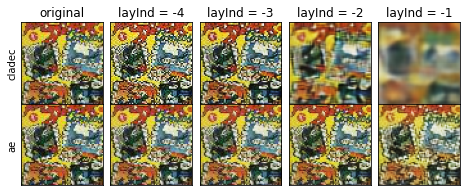

In [52]:
flag = False
from tqdm import tqdm
i=0
num_correct = 0
num_incorrect = 0
for j in tqdm(range(len(batch_ordered))):
    if flag == True:
        break
    for k in range(len(batch_ordered[j][0])):
        if k > 4: 
            break
        
        orig = format_img(batch_ordered[j][0][k])
        label = batch_ordered[j][1][k].item()
        pred = clf_preds[j][k].item()
        i = i+1
        
        if (pred!=label and num_incorrect < 200) or (pred == label and num_correct < 200):
            if pred != label:
                img_name = "img_" + str(i) + "_label_" + str(label) + "_pred_" + str(pred) + ".jpg"
                path = os.path.join(incorrect_path, img_name)
                num_incorrect +=1
            else:
                img_name = "img_" + str(i) + "_label_" + str(label) + ".jpg"
                path = os.path.join(correct_path, img_name)
                num_correct += 1
        else:
            flag=True
            break

        #if label ==pred:
        #if i> 300:
        #    flag=True
        #    break
        ae_imgs = {t : format_img(reconstr_ae[t][j][k]) for t in reconstr_ae.keys()}
        cladec_imgs = {t : format_img(reconstr_cladec[t][j][k]) for t in reconstr_cladec.keys()}
        plt.rcParams["figure.figsize"] = (8,3)
        ax = plt.subplot(2,5,1)
        plotter(ax, orig, title="original", ylabel="cladec")
        ax = plt.subplot(2,5,6)
        plotter(ax, orig, ylabel="ae")
        for t in ae_imgs.keys():
            ax = plt.subplot(2,5,6 - t)
            plotter(ax, cladec_imgs[t], title="layInd = -" + str(t))
            ax = plt.subplot(2,5,11 - t)
            plotter(ax, ae_imgs[t])
        plt.subplots_adjust(hspace=0, wspace=0)
        #plt.show()
        plt.savefig(path)


In [10]:
clf_cladec = ResNet10(n_classes = cfg["ds"][1], n_output_planes = [64, 128, 256, 512], inch = cfg["imCh"]).cuda()
clf_cladec.load_state_dict(torch.load(os.path.join(model_path, "clf_cladec_1.pt")))
clf_cladec.eval()

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): 

In [13]:
getAcc(clf_cladec, val_loader,  niter=10000,norm=None)

0.0058